In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class AttentionBlock(nn.Module):
    def __init__(self, in_features):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_features, 1, kernel_size=1, stride=1, padding=0, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.sigmoid(self.conv(x))
        return x * attention

class Generator(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, num_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=0, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Attention block
        model += [AttentionBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels=2):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCEWithLogitsLoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

# Initialize models and move them to GPU
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss functions
criterion_GAN = GANLoss(use_lsgan=True).to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Learning rate scheduler
lr_scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.1)
lr_scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=50, gamma=0.1)

def train(train_dataloader, val_dataloader, num_epochs, save_interval=10):
    os.makedirs("images", exist_ok=True)
    os.makedirs("saved_models", exist_ok=True)

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        # Training
        for i, (real_A, real_B) in enumerate(train_dataloader):
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()

            # Generate fake images
            fake_B = generator(real_A)

            # Real loss
            pred_real = discriminator(real_A, real_B)
            loss_D_real = criterion_GAN(pred_real, True)

            # Fake loss
            pred_fake = discriminator(real_A, fake_B.detach())
            loss_D_fake = criterion_GAN(pred_fake, False)

            # Total discriminator loss
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            # GAN loss
            pred_fake = discriminator(real_A, fake_B)
            loss_G_GAN = criterion_GAN(pred_fake, True)

            # Cycle consistency loss
            reconstructed_A = generator(fake_B)
            loss_cycle = criterion_cycle(reconstructed_A, real_A)

            # Identity loss
            same_B = generator(real_B)
            loss_identity = criterion_identity(same_B, real_B)

            # Total generator loss
            loss_G = loss_G_GAN + loss_cycle*10 + loss_identity*5
            loss_G.backward()
            optimizer_G.step()

            # Print training progress
            if i % 100 == 0:
                print(f"[Training] Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_dataloader)}], "
                      f"D_loss: {loss_D.item():.4f}, G_loss: {loss_G.item():.4f}")

        # Validation
        generator.eval()
        discriminator.eval()
        val_loss_G = 0
        val_loss_D = 0

        with torch.no_grad():
            for i, (real_A, real_B) in enumerate(val_dataloader):
                real_A = real_A.to(device)
                real_B = real_B.to(device)

                # Generate fake images
                fake_B = generator(real_A)

                # Discriminator loss
                pred_real = discriminator(real_A, real_B)
                loss_D_real = criterion_GAN(pred_real, True)
                pred_fake = discriminator(real_A, fake_B.detach())
                loss_D_fake = criterion_GAN(pred_fake, False)
                loss_D = (loss_D_real + loss_D_fake) * 0.5

                # Generator loss
                pred_fake = discriminator(real_A, fake_B)
                loss_G_GAN = criterion_GAN(pred_fake, True)
                reconstructed_A = generator(fake_B)
                loss_cycle = criterion_cycle(reconstructed_A, real_A)
                same_B = generator(real_B)
                loss_identity = criterion_identity(same_B, real_B)
                loss_G = loss_G_GAN + loss_cycle * 10.0 + loss_identity * 5.0

                val_loss_D += loss_D.item()
                val_loss_G += loss_G.item()

                # Save some validation images
                if i == 0:
                    save_image(torch.cat((real_A.cpu(), fake_B.cpu(), real_B.cpu()), -2),
                               f"images/epoch_{epoch}_validation.png", normalize=True)

        val_loss_D /= len(val_dataloader)
        val_loss_G /= len(val_dataloader)
        print(f"[Validation] Epoch [{epoch}/{num_epochs}], "
              f"D_loss: {val_loss_D:.4f}, G_loss: {val_loss_G:.4f}")

        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D.step()

        # Save models periodically
        if (epoch + 1) % save_interval == 0:
            torch.save(generator.state_dict(), f"saved_models/generator_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"saved_models/discriminator_{epoch}.pth")

# Usage example (commented out)
# import torchvision.transforms as transforms
# from torch.utils.data import Dataset
#
# class YourDataset(Dataset):
#     def __init__(self, data_path, transform=None):
#         # Implement your dataset here
#         pass
#
#     def __getitem__(self, index):
#         # Return a pair of images (input, target)
#         pass
#
#     def __len__(self):
#         # Return the size of the dataset
#         pass
#
# # Define transforms
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])
#
# # Create datasets
# train_dataset = YourDataset('path/to/train/data', transform=transform)
# val_dataset = YourDataset('path/to/val/data', transform=transform)
#
# # Create dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
#
# # Train the model
# train(train_dataloader, val_dataloader, num_epochs=200)

Using device: cuda


In [47]:
# prompt: create Dataset to load image from a given folder preprocess with function create_masked_image() and a given transformation then return image, processed image and mask

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
from PIL import Image
import os

# Path to the folder
folder_path = '/GPR_DATA'

# Count the number of files in the folder
num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])


class PairedImageDataset(Dataset):
    def __init__(self, label_dir, transform=None, input_shape=(1, 640, 640)):
        self.label_dir = label_dir
        self.transform = transform
        self.input_shape = input_shape

        # Get list of image files in label directory
        self.label_files = [f for f in os.listdir(label_dir) if f.endswith(('.jpg', '.png'))]
        num_files = len(self.label_files)

        # Create random input tensor
        self.input_tensor = torch.rand(num_files, *self.input_shape)

        # Default transform to convert PIL image to tensor if none is provided
        if self.transform is None:
            self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.label_files)

    def __getitem__(self, idx):
        label_img_name = self.label_files[idx]
        label_img_path = os.path.join(self.label_dir, label_img_name)

        # Load and transform label image
        label_image = Image.open(label_img_path).convert('L')
        label_tensor = self.transform(label_image)
        label_tensor = transforms.ToTensor()(label_tensor)

        # Get corresponding input tensor
        input_tensor = self.input_tensor[idx]

        return input_tensor, label_tensor

# Example usage:
transform = transforms.Compose([
    transforms.Resize((640, 640))
    # Add other transformations as needed
    ])

In [48]:
label_dir = '/GPR_DATA'

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    # Add other transformations as needed
])

dataset = PairedImageDataset(label_dir, transform=transform)

# Split into train and validation sets
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
train(train_loader,val_loader,num_epochs=1000)

[Training] Epoch [0/1000], Step [0/55], D_loss: 0.2935, G_loss: 3.0383
[Validation] Epoch [0/1000], D_loss: 0.1583, G_loss: 3.0517
[Training] Epoch [1/1000], Step [0/55], D_loss: 0.0536, G_loss: 3.0673
[Validation] Epoch [1/1000], D_loss: 0.1583, G_loss: 3.0517
[Training] Epoch [2/1000], Step [0/55], D_loss: 0.2840, G_loss: 3.0306
[Validation] Epoch [2/1000], D_loss: 0.1583, G_loss: 3.0517
[Training] Epoch [3/1000], Step [0/55], D_loss: 0.0592, G_loss: 3.0334
[Validation] Epoch [3/1000], D_loss: 0.1583, G_loss: 3.0517
[Training] Epoch [4/1000], Step [0/55], D_loss: 0.2537, G_loss: 3.0551
[Validation] Epoch [4/1000], D_loss: 0.1583, G_loss: 3.0517
[Training] Epoch [5/1000], Step [0/55], D_loss: 0.0592, G_loss: 3.0360
[Validation] Epoch [5/1000], D_loss: 0.1583, G_loss: 3.0517
[Training] Epoch [6/1000], Step [0/55], D_loss: 0.1527, G_loss: 3.0743
[Validation] Epoch [6/1000], D_loss: 0.1583, G_loss: 3.0517
[Training] Epoch [7/1000], Step [0/55], D_loss: 0.0548, G_loss: 3.0464
[Validation]

In [37]:
txi=torch.rand((1,640,640)).to(device)

In [38]:
generator.eval()
x=generator(txi)

In [27]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 109.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 39.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 30.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [35]:
x.shape

torch.Size([1, 640, 640])

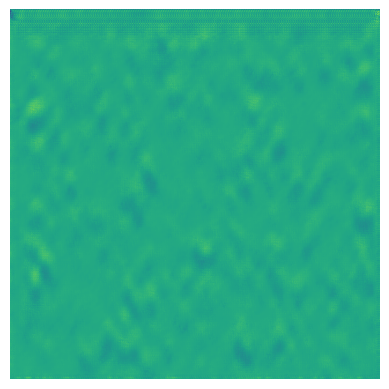

In [43]:
import matplotlib.pyplot as plt

txi=torch.rand((1,640,640)).to(device)

generator.eval()
x=generator(txi)
# Move the tensor to CPU and convert to numpy array
cpu_tensor = x.cpu().detach().numpy()
cpu_tensor = cpu_tensor.squeeze()

# Plot the image
plt.imshow(cpu_tensor)
plt.axis('off')  # Turn off axis labels
plt.show()